<a href="https://colab.research.google.com/github/sehan25/ESAA-2022-2/blob/main/Session/1205-kaggle-Keras%20CNN%20Dog%20or%20Cat%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [6]:
import numpy as np
import pandas as pd 
from tensorflow.keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

from google.colab import drive
drive.mount('/content/drive')

print(os.listdir("/content/drive/MyDrive/ESAA/data/kaggle/keras-cnn"))

Mounted at /content/drive
['test_500', 'train_700']


- Define Constants

In [7]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

## Prepare Traning Data

In [9]:
filenames = os.listdir("/content/drive/MyDrive/ESAA/data/kaggle/keras-cnn/train_700")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [10]:
df.head()

,filename,category
0,dog.456.jpg,1
1,dog.463.jpg,1
2,dog.465.jpg,1
3,dog.464.jpg,1
4,dog.466.jpg,1


In [11]:
df.tail()

,filename,category
1397,dog.458.jpg,1
1398,dog.460.jpg,1
1399,dog.46.jpg,1
1400,dog.459.jpg,1
1401,dog.457.jpg,1


- See Total in count

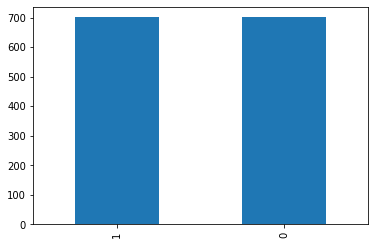

In [12]:
df['category'].value_counts().plot.bar()

- See sample image

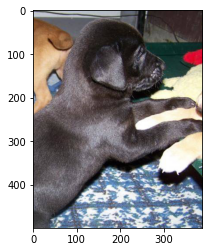

In [14]:
sample = random.choice(filenames)
image = load_img("/content/drive/MyDrive/ESAA/data/kaggle/keras-cnn/train_700/"+sample)
plt.imshow(image)

## Build Model
- Input Layer: It represent input image data. It will reshape image into single diminsion array.  
ex) image(64x64) &rarr; (4096,1) array. (64x64=4096)
- Conv Layer: extract features from image
- Pooling Layer: reduce the spatial volume of input image after convolution
- Fully Connected Layer: connect the network from a layer to another layer
- Output Layer: predicted values layer

In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

### Callbacks

In [38]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

- Early Stop - to prevent over fitting

In [39]:
earlystop = EarlyStopping(patience=10)

- reduce the learning rate when then accuracy not increase for 2 steps

In [40]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [41]:
callbacks = [earlystop, learning_rate_reduction]

## Prepare data
- One-Hot encoding - convert column category into string

In [42]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [43]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

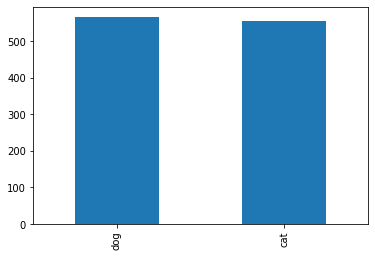

In [44]:
train_df['category'].value_counts().plot.bar()

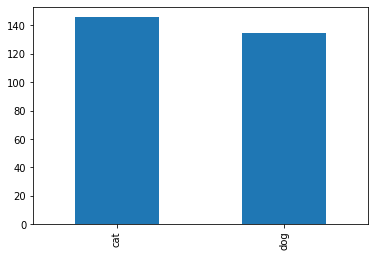

In [45]:
validate_df['category'].value_counts().plot.bar()

In [46]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

## Traning Generator

In [55]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/drive/MyDrive/ESAA/data/kaggle/keras-cnn/train_700/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1121 validated image filenames belonging to 2 classes.


In [56]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/ESAA/data/kaggle/keras-cnn/train_700/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 281 validated image filenames belonging to 2 classes.


### See how our generator work

In [57]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/content/drive/MyDrive/ESAA/data/kaggle/keras-cnn/train_700/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


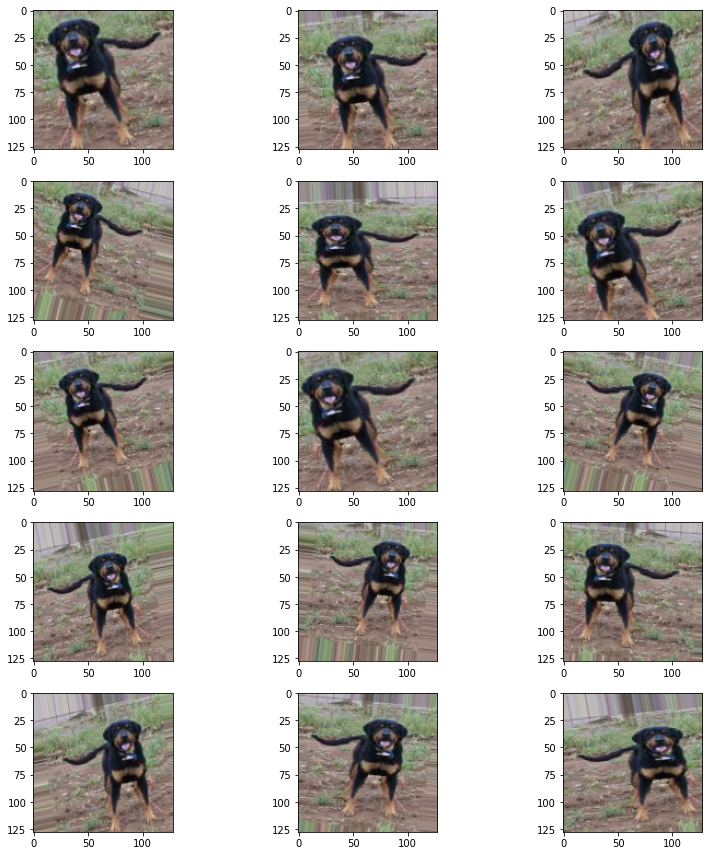

In [58]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Fit Model

In [59]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

<ipython-input-59-63cb34b6e89a>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
74/74 [==============================] - ETA: 0s - loss: 1.3789 - accuracy: 0.5678

74/74 [==============================] - 263s 4s/step - loss: 1.3789 - accuracy: 0.5678 - val_loss: 3.4430 - val_accuracy: 0.5296 - lr: 0.0010
Epoch 2/50
74/74 [==============================] - ETA: 0s - loss: 1.0501 - accuracy: 0.5823

74/74 [==============================] - 38s 515ms/step - loss: 1.0501 - accuracy: 0.5823 - val_loss: 2.2212 - val_accuracy: 0.5222 - lr: 0.0010
Epoch 3/50
74/74 [==============================] - ETA: 0s - loss: 0.9189 - accuracy: 0.6004

74/74 [==============================] - 37s 495ms/step - loss: 0.9189 - accuracy: 0.6004 - val_loss: 2.3298 - val_accuracy: 0.5222 - lr: 0.0010
Epoch 4/50
74/74 [==============================] - ETA: 0s - loss: 0.7773 - accuracy: 0.6347

74/74 [==============================] - 37s 497ms/step - loss: 0.7773 - accuracy: 0.6347 - val_loss: 2.2025 - val_accuracy: 0.5296 - lr: 0.0010
Epoch 5/50
74/74 [==============================] - ETA: 0s - loss: 0.7046 - accuracy: 0.6618

74/74 [==============================] - 37s 496ms/step - loss: 0.7046 - accuracy: 0.6618 - val_loss: 1.0971 - val_accuracy: 0.5519 - lr: 0.0010
Epoch 6/50
74/74 [==============================] - ETA: 0s - loss: 0.6725 - accuracy: 0.6718

74/74 [==============================] - 37s 496ms/step - loss: 0.6725 - accuracy: 0.6718 - val_loss: 0.8208 - val_accuracy: 0.5704 - lr: 0.0010
Epoch 7/50
74/74 [==============================] - ETA: 0s - loss: 0.6257 - accuracy: 0.6808

74/74 [==============================] - 37s 494ms/step - loss: 0.6257 - accuracy: 0.6808 - val_loss: 0.7079 - val_accuracy: 0.6593 - lr: 0.0010
Epoch 8/50
74/74 [==============================] - ETA: 0s - loss: 0.6071 - accuracy: 0.6835

74/74 [==============================] - 38s 513ms/step - loss: 0.6071 - accuracy: 0.6835 - val_loss: 1.0566 - val_accuracy: 0.5926 - lr: 0.0010
Epoch 9/50
74/74 [==============================] - ETA: 0s - loss: 0.5963 - accuracy: 0.6998

74/74 [==============================] - 37s 497ms/step - loss: 0.5963 - accuracy: 0.6998 - val_loss: 0.6204 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 10/50
74/74 [==============================] - ETA: 0s - loss: 0.6094 - accuracy: 0.6863

74/74 [==============================] - 37s 498ms/step - loss: 0.6094 - accuracy: 0.6863 - val_loss: 0.6777 - val_accuracy: 0.6741 - lr: 0.0010
Epoch 11/50
74/74 [==============================] - ETA: 0s - loss: 0.5813 - accuracy: 0.7089

74/74 [==============================] - 37s 498ms/step - loss: 0.5813 - accuracy: 0.7089 - val_loss: 0.6934 - val_accuracy: 0.6889 - lr: 0.0010
Epoch 12/50
74/74 [==============================] - ETA: 0s - loss: 0.5502 - accuracy: 0.7378

74/74 [==============================] - 37s 501ms/step - loss: 0.5502 - accuracy: 0.7378 - val_loss: 0.7043 - val_accuracy: 0.7037 - lr: 0.0010
Epoch 13/50
74/74 [==============================] - ETA: 0s - loss: 0.5520 - accuracy: 0.7215

74/74 [==============================] - 37s 496ms/step - loss: 0.5520 - accuracy: 0.7215 - val_loss: 0.7164 - val_accuracy: 0.6222 - lr: 0.0010
Epoch 14/50
74/74 [==============================] - ETA: 0s - loss: 0.5321 - accuracy: 0.7441

74/74 [==============================] - 37s 498ms/step - loss: 0.5321 - accuracy: 0.7441 - val_loss: 0.5721 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 15/50
74/74 [==============================] - ETA: 0s - loss: 0.5138 - accuracy: 0.7477

74/74 [==============================] - 37s 498ms/step - loss: 0.5138 - accuracy: 0.7477 - val_loss: 0.6131 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 16/50
74/74 [==============================] - ETA: 0s - loss: 0.4992 - accuracy: 0.7731

74/74 [==============================] - 37s 495ms/step - loss: 0.4992 - accuracy: 0.7731 - val_loss: 0.6891 - val_accuracy: 0.6593 - lr: 0.0010
Epoch 17/50
74/74 [==============================] - ETA: 0s - loss: 0.5146 - accuracy: 0.7586

74/74 [==============================] - 37s 495ms/step - loss: 0.5146 - accuracy: 0.7586 - val_loss: 0.5767 - val_accuracy: 0.7296 - lr: 0.0010
Epoch 18/50
74/74 [==============================] - ETA: 0s - loss: 0.4813 - accuracy: 0.7685

74/74 [==============================] - 37s 500ms/step - loss: 0.4813 - accuracy: 0.7685 - val_loss: 0.6241 - val_accuracy: 0.7037 - lr: 0.0010
Epoch 19/50
74/74 [==============================] - ETA: 0s - loss: 0.4953 - accuracy: 0.7523

74/74 [==============================] - 38s 514ms/step - loss: 0.4953 - accuracy: 0.7523 - val_loss: 0.5776 - val_accuracy: 0.7370 - lr: 0.0010
Epoch 20/50
74/74 [==============================] - ETA: 0s - loss: 0.4833 - accuracy: 0.7676

74/74 [==============================] - 37s 500ms/step - loss: 0.4833 - accuracy: 0.7676 - val_loss: 0.6411 - val_accuracy: 0.7259 - lr: 0.0010
Epoch 21/50
74/74 [==============================] - ETA: 0s - loss: 0.4934 - accuracy: 0.7712

74/74 [==============================] - 37s 497ms/step - loss: 0.4934 - accuracy: 0.7712 - val_loss: 0.6320 - val_accuracy: 0.7222 - lr: 0.0010
Epoch 22/50
74/74 [==============================] - ETA: 0s - loss: 0.4799 - accuracy: 0.7848

74/74 [==============================] - 37s 499ms/step - loss: 0.4799 - accuracy: 0.7848 - val_loss: 0.6453 - val_accuracy: 0.6889 - lr: 0.0010
Epoch 23/50
74/74 [==============================] - ETA: 0s - loss: 0.4228 - accuracy: 0.8192

74/74 [==============================] - 37s 500ms/step - loss: 0.4228 - accuracy: 0.8192 - val_loss: 0.6904 - val_accuracy: 0.7037 - lr: 0.0010
Epoch 24/50
74/74 [==============================] - ETA: 0s - loss: 0.4719 - accuracy: 0.7857

74/74 [==============================] - 37s 499ms/step - loss: 0.4719 - accuracy: 0.7857 - val_loss: 0.6262 - val_accuracy: 0.7370 - lr: 0.0010


### Save Model

In [60]:
model.save_weights("model.h5")

## Virtualize Training

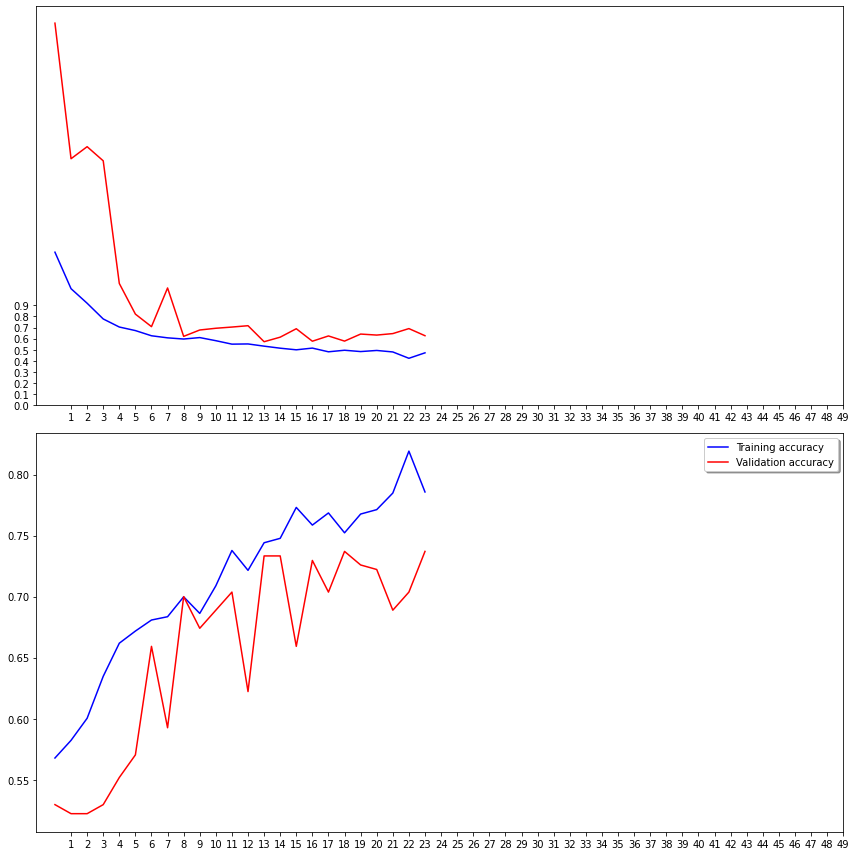

In [62]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Prepare Testing Data

In [63]:
test_filenames = os.listdir("/content/drive/MyDrive/ESAA/data/kaggle/keras-cnn/test_500")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

## Create Testing Generator

In [64]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/drive/MyDrive/ESAA/data/kaggle/keras-cnn/test_500/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 500 validated image filenames.


## Predict

In [65]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

<ipython-input-65-52619fd72ccc>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


- pick the category that have the highest probability with numpy average max

In [66]:
test_df['category'] = np.argmax(predict, axis=-1)

- convert the predict category back into our generator classes
    - by using train_generator.class_indices: classes that image generator map while converting data into computer vision

In [67]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [68]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

### Virtaulize Result

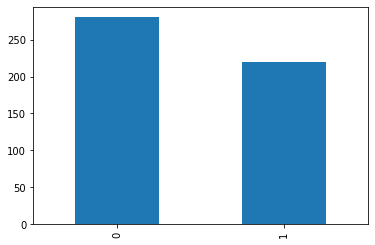

In [69]:
test_df['category'].value_counts().plot.bar()

- See predicted result with images

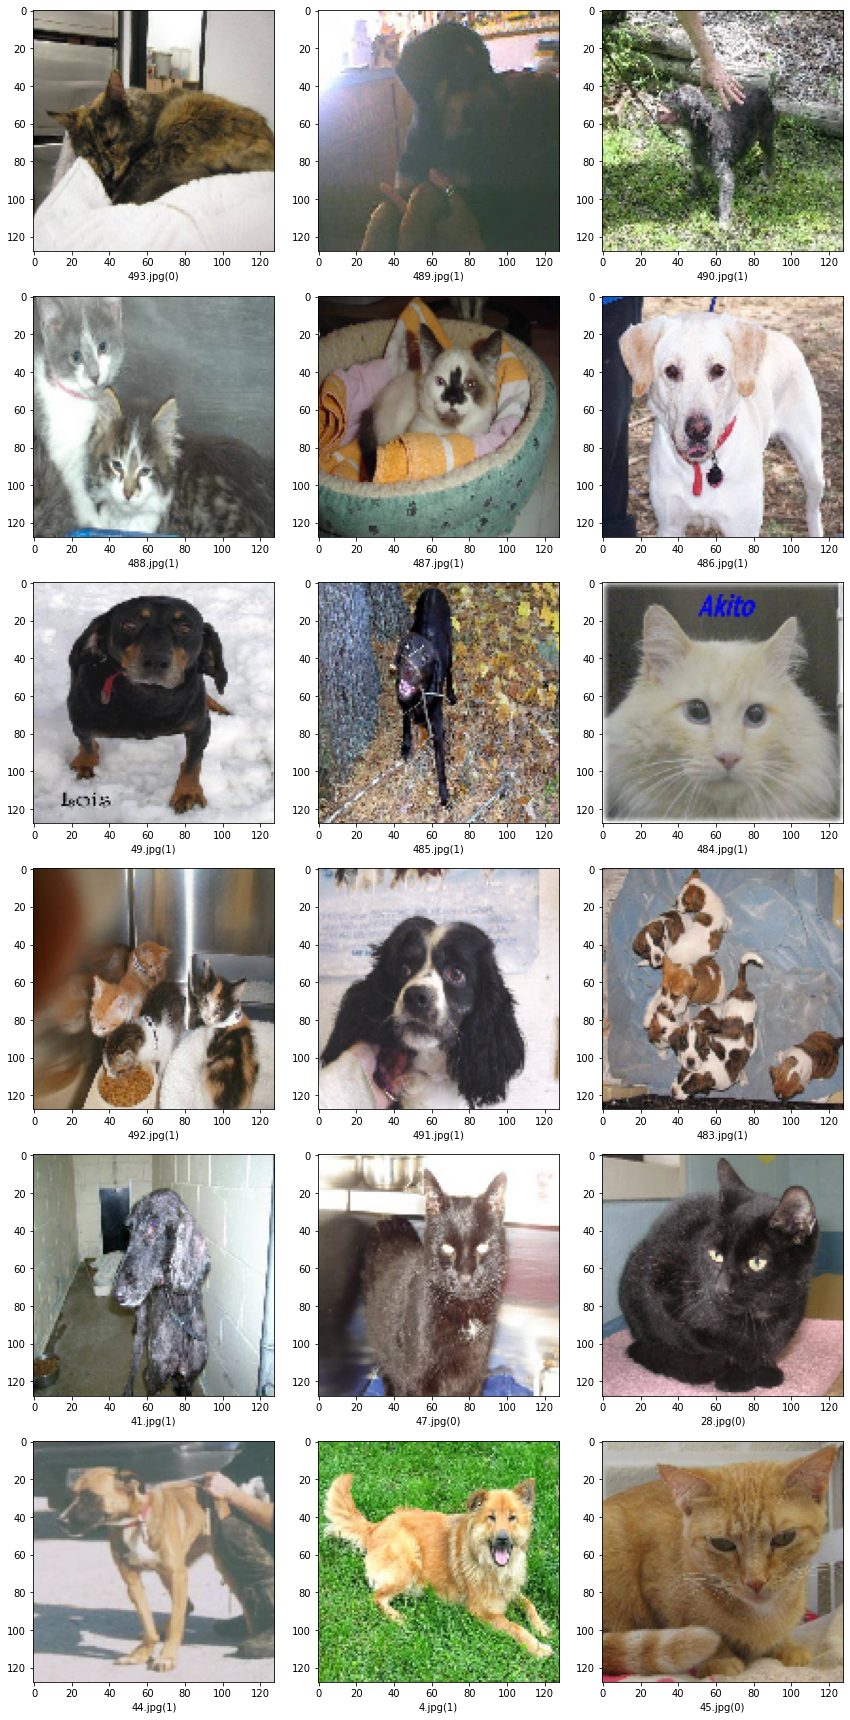

In [70]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/drive/MyDrive/ESAA/data/kaggle/keras-cnn/test_500/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

## Submission

In [71]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)